In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class ResBlock(nn.Module):
    def __init__(self, hidden_channels = 256, wheretouse = "encoder"):
        super(ResBlock, self).__init__()
        
        if wheretouse == "encoder":
            self.resblk = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1),
                nn.ReLU(),
                nn.Conv2d(hidden_channels, hidden_channels, 1, 1, 0)
            )
        elif wheretouse == "decoder":
            self.resblk = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(hidden_channels, hidden_channels, 1, 1, 0),
                nn.ReLU(),
                nn.Conv2d(hidden_channels, hidden_channels, 3, 1, 1)
            )
        
    def forward(self, x):
        
        return torch.relu(x + self.resblk(x))

In [3]:
res = ResBlock()
outres = res(torch.randn(2, 256, 8, 8))
outres.shape

torch.Size([2, 256, 8, 8])

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_residual_layers = 2):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels // 2, 4, 2, 1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_channels // 2, hidden_channels, 4, 2, 1))
        self.num_residual_layers = num_residual_layers
        self.resblk = nn.Sequential(*[ResBlock(wheretouse = "encoder") for _ in range(num_residual_layers)])
        self.conv_latent = nn.Conv2d(hidden_channels, latent_dim, 1, 1, 0)  #Just that the output of the residual blocks now gets mapped to the latent space.
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.resblk(x)
        ze_x = self.conv_latent(x)
        
        return ze_x

In [7]:
encoder = Encoder(3, 256, 64, 2)
out = encoder(torch.randn(2, 3, 32, 32))
out.shape

torch.Size([2, 64, 8, 8])

In [4]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim, hidden_channels, num_residual_layers = 2):
        super(Decoder, self).__init__()
        
        self.convdec = nn.Conv2d(latent_dim, hidden_channels, 1, 1, 0)    # Just to project from latent dimension to the hidden_channel dimension
        self.resblkdec = nn.Sequential(*[ResBlock(wheretouse = "decoder") for _ in range(num_residual_layers)])
        
        self.convT1 = nn.Sequential(nn.ConvTranspose2d(hidden_channels, hidden_channels // 2, 4, 2, 1), nn.ReLU())
        self.convT2 = nn.ConvTranspose2d(hidden_channels // 2, out_channels, 4, 2, 1)
        
    def forward(self, x):
        
        x = self.convdec(x)
        x = self.resblkdec(x)
        x = self.convT1(x)
        x_cap = self.convT2(x)
        
        return x_cap
        

In [9]:
decoder = Decoder(3, 64, 256)
out3 = decoder(out)
out3.shape

torch.Size([2, 3, 32, 32])

In [5]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta, epsilon = 1e-10):
        super(VectorQuantizer, self).__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        # self.decay = decay
        self.beta = beta
        self.epsilon = epsilon
        
        embedding = torch.Tensor(self.num_embeddings, self.embedding_dim)
        init_bound = 1/self.num_embeddings
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(self.num_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())
        
    
    def forward(self, x):
        
        K, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p = 2)) ** 2   #outputs a matrix of size(x_flat.size()[0], K), with each entry being the distance between x_flat 
        
        indices = torch.argmin(distances.float(), dim = -1)    #A (x_flat.size[0], 1) shaped vector, whose each entry give the index of the latent vector, to which corresponding x_flat vector has the minimum distance from it.
        encoding = F.one_hot(indices, K).float()
        quantized = F.embedding(indices, self.embedding)    # selects the embedding vector corresponding to index from range {1, 2, 3, ..., K}
        # quantized_mod = quantized.view_as(x)
        
        
        # codebook_loss = F.mse_loss(x.detach(), quantized_mod)   #why not x_flat and quantized
        # commitment_loss = self.beta*F.mse_loss(x, quantized_mod.detach())
        codebook_loss = F.mse_loss(x_flat.detach(), quantized)
        commitment_loss = self.beta*F.mse_loss(x_flat, quantized.detach())
        
        # quantized_mod = x + (quantized_mod - x).detach()  #while forward quantized  = quantized, while backward pass, quantized = x why??
        quantized = x_flat + (quantized - x_flat).detach()
        
        avg_probs = torch.mean(encoding, dim = 0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + self.epsilon)))
        
        return quantized, codebook_loss, commitment_loss, perplexity
        

In [12]:
vq = VectorQuantizer(512, 64, 0.25)
out2 = vq(out)
out2[0].shape

torch.Size([128, 64])

In [6]:
class VQVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_embeddings, embedding_dim, beta, num_residual_layers = 2):
        super(VQVAE, self).__init__()
        
        self.encoder = Encoder(in_channels, hidden_channels, latent_dim)
        self.decoder = Decoder(in_channels,latent_dim, hidden_channels)
        self.vectorquantizer = VectorQuantizer(num_embeddings, embedding_dim, beta)
        
    def forward(self, x):
        
        ze_x = self.encoder(x)
        zq_x, codebook_loss, commitment_loss, perplexity = self.vectorquantizer(ze_x)
        zq_x = zq_x.view_as(ze_x)
        x_cap = self.decoder(zq_x)
        
        return x_cap, codebook_loss, commitment_loss, perplexity

In [7]:
BATCH_SIZE = 128
IN_CHANNELS = 3
HIDDEN_CHANNELS = 256
LATENT_DIM = 64
NUM_EMBEDDINGS = 512
EMBEDDING_DIM = 64
BETA = 0.25
lr = 2e-4

NUM_EPOCHS = 50

In [8]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
vqvae = VQVAE(in_channels = IN_CHANNELS, hidden_channels = HIDDEN_CHANNELS, latent_dim = LATENT_DIM, num_embeddings = NUM_EMBEDDINGS, embedding_dim = EMBEDDING_DIM, beta = BETA).to(DEVICE)

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root = "/mnt/External/8TBHDD/AdityaAshokBarot", train = True, transform = transform, download = True)
val_dataset = datasets.CIFAR10(root = "/mnt/External/8TBHDD/AdityaAshokBarot", train = False, transform = transform, download = True)

kwargs = {"pin_memory": True, "num_workers":4}

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, **kwargs)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, **kwargs)

print_step = 50

Files already downloaded and verified
Files already downloaded and verified


In [10]:
optimizer = torch.optim.Adam(vqvae.parameters(), lr = lr)
loss_criteria = nn.MSELoss()

In [11]:
print("Training of VQVAE starts here...")

vqvae.train()

for epoch in range(NUM_EPOCHS):
    # overall_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        
        x_cap, codebook_loss, commitment_loss, perplexity = vqvae(x)
        
        reconstruction_loss = loss_criteria(x_cap, x)
        total_loss = reconstruction_loss + codebook_loss + commitment_loss
        
        total_loss.backward()
        optimizer.step()
        
        if batch_idx % print_step == 0:
            print(f"Epoch {epoch + 1}\t batch_idx {batch_idx + 1}\t reconstruction_loss = {reconstruction_loss}\t codebook_loss = {codebook_loss} \t commitment_loss = {commitment_loss}\n, perplexity = {perplexity} " )

Training of VQVAE starts here...
Epoch 1	 batch_idx 1	 reconstruction_loss = 0.22410301864147186	 codebook_loss = 0.005843248218297958 	 commitment_loss = 0.0014608120545744896
, perplexity = 48.89448547363281 
Epoch 1	 batch_idx 51	 reconstruction_loss = 0.06819945573806763	 codebook_loss = 0.005990517791360617 	 commitment_loss = 0.0014976294478401542
, perplexity = 45.87410354614258 
Epoch 1	 batch_idx 101	 reconstruction_loss = 0.06551588326692581	 codebook_loss = 0.006089808885008097 	 commitment_loss = 0.0015224522212520242
, perplexity = 49.48781204223633 
Epoch 1	 batch_idx 151	 reconstruction_loss = 0.06296887993812561	 codebook_loss = 0.006232056766748428 	 commitment_loss = 0.001558014191687107
, perplexity = 47.83594512939453 
Epoch 1	 batch_idx 201	 reconstruction_loss = 0.06200924143195152	 codebook_loss = 0.006113016977906227 	 commitment_loss = 0.0015282542444765568
, perplexity = 46.80949401855469 
Epoch 1	 batch_idx 251	 reconstruction_loss = 0.06462837010622025	 code

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def draw_sample_image(x, postfix):
      
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [14]:
vqvae.eval()

VQVAE(
  (encoder): Encoder(
    (conv1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (conv2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (resblk): Sequential(
      (0): ResBlock(
        (resblk): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResBlock(
        (resblk): Sequential(
          (0): ReLU()
          (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
    (conv_latent): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Decoder(
    (convdec): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (resblkdec): Sequential(
    

In [15]:
with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(val_dataloader)):

        x = x.to(DEVICE)
        x_cap, codebook_loss, commitment_loss, perplexity = vqvae(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  50.04872131347656 commit_loss:  0.0014450743328779936   codebook loss:  0.005780297331511974


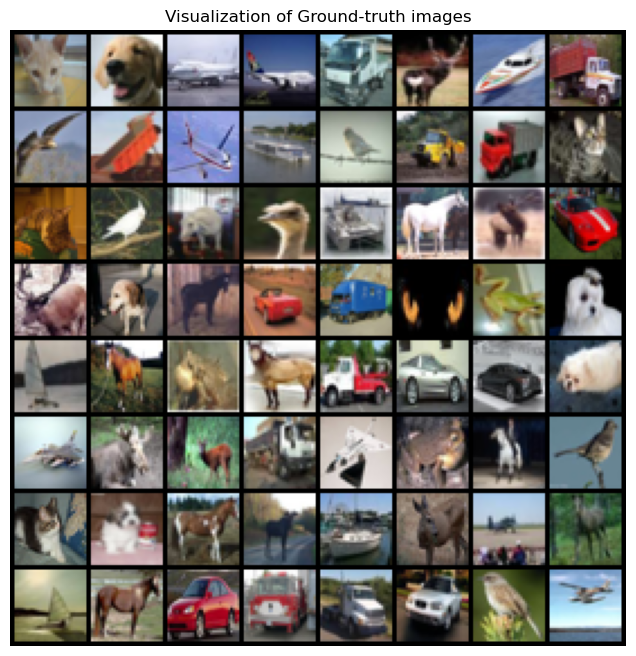

In [16]:
draw_sample_image(x[:BATCH_SIZE//2], "Ground-truth images")

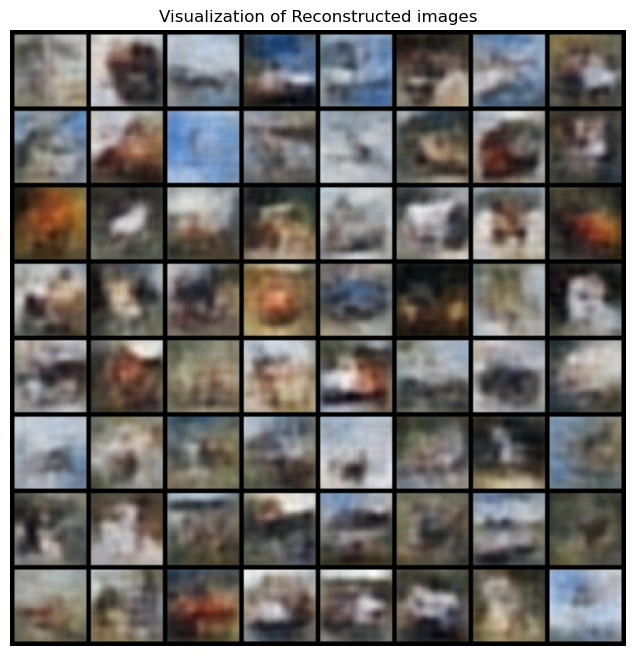

In [17]:
draw_sample_image(x_cap[:BATCH_SIZE//2], "Reconstructed images")